In [3]:
import sys
import pickle as pl
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
import seaborn as sns
from getdist import plots, MCSamples
sys.path.append('../')

In [4]:
%load_ext autoreload
%autoreload 2
from quest import Reconstruction

In [5]:
rec1 = Reconstruction.from_ini('LB_FG0.ini')
rec2 = Reconstruction.from_ini('LB_FG1.ini')
rec3 = Reconstruction.from_ini('LB_FG2.ini')

DATABASE: loaded
SIMUALATION object with out FG: Loaded
FILTERING object with out FG: Loaded
QUEST object with out FG: Loaded
DATABASE: loaded
SIMUALATION object with  FG: Loaded
FILTERING object with  FG: Loaded
QUEST object with  FG: Loaded
DATABASE: loaded
SIMUALATION object with  FG: Loaded
FILTERING object with  FG: Loaded
QUEST object with  FG: Loaded


In [6]:
class crazymix:
    
    def __init__(self,s1d1,other,idx=0):
        self.s1d1 = s1d1
        self.other = other
        self.idx = idx
        self.B = self.s1d1.B
        self.fiducial = self.other.bin_cell(self.other.cl_pp*self.other.Lfac)
        self.icov = self.icov_()
        self.spectra = self.get_spectra()
        
    def get_data(self):
        return self.s1d1.get_phi_cl(self.idx)
    
    def get_spectra(self):
        
        cl = (self.get_data() - 
              self.other.N1 - 
              self.other.RDN0(self.idx))/self.other.response_mean()**2
    
        correction = ((self.other.RDN0(self.idx)/self.other.response_mean()**2)+self.other.cl_pp)/100
        
        return self.other.bin_cell((cl-correction)*self.s1d1.Lfac)
    
    def icov_(self):
        return np.linalg.inv(np.cov(self.other.get_qcl_wR_stat().T))
    
    def chi_sq(self,alens):
        dcl = self.spectra - (alens*self.fiducial)
        return np.dot(dcl,np.dot(self.icov,dcl))
    
    
    def log_prior(self,theta):
        if 0.5 < theta < 1.5:
            return 0.0
        return -np.inf

    def log_likelihood(self,theta,):
        return -0.5 * self.chi_sq(theta)

    def log_probability(self,theta):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(theta)
    
    def get_samples(self):
        pos = [1] + 1e-1 * np.random.randn(64, 1)
        nwalkers,ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers,ndim,self.log_probability)
        sampler.run_mcmc(pos, 4000, progress=True)
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        return flat_samples
        

In [22]:
c = crazymix(rec3,rec1,100)
snofg = c.get_samples()

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 4000/4000 [00:03<00:00, 1100.20it/s]


In [23]:
c = crazymix(rec3,rec2,100)
sfg1 = c.get_samples()

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 4000/4000 [00:03<00:00, 1102.49it/s]


In [32]:
c = crazymix(rec3,rec3,100)
sfg2 = c.get_samples()

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 4000/4000 [00:03<00:00, 1104.02it/s]


In [33]:
names = ["Alens"]
labels =  ["A_\mathrm{lens}"]
nofg = MCSamples(samples=snofg,names=names,labels=labels, label='No FG')
fg1 = MCSamples(samples=sfg1,names=names,labels=labels, label='s0d0')
fg2 = MCSamples(samples=sfg2,names=names,labels=labels, label='s1d1')

Removed no burn in
Removed no burn in
Removed no burn in


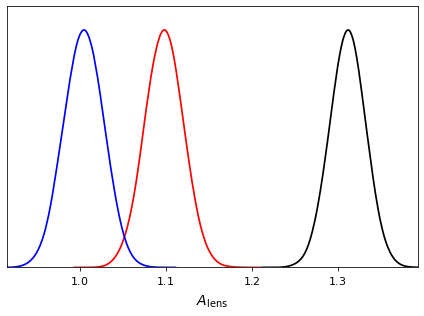

In [34]:
g = plots.get_single_plotter(width_inch=6)
g.plot_1d([nofg,fg1,fg2], 'Alens',)